In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [108]:
bs = 128

In [109]:
# Load Data
dataset = datasets.ImageFolder(root='/Users/jagtarsingh/OneDrive/UPenn/CIS680/VAE/celeba', transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
len(dataset.imgs), len(dataloader)

(202599, 1583)

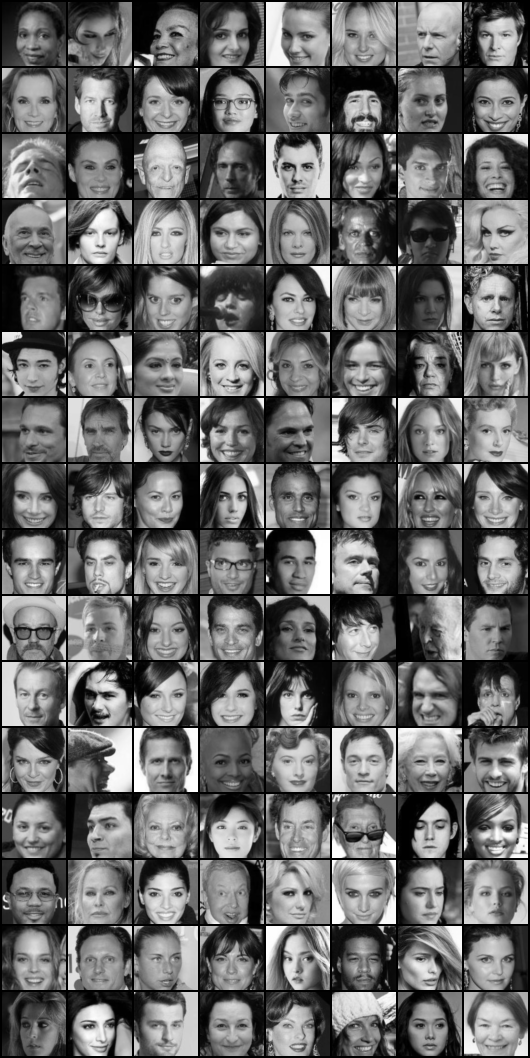

In [110]:
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [111]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [112]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [113]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=64):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [114]:
image_channels = fixed_x.size(1)
print(image_channels)

3


In [115]:
model = VAE(image_channels=image_channels).to(device)
# model.load_state_dict(torch.load('vae.torch', map_location='cpu'))

In [116]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [117]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [118]:
!rm -rfr reconstructed
!mkdir reconstructed

In [119]:
epochs = 50

In [120]:
for epoch in range(epochs):
    for idx, (images, _) in enumerate(dataloader):
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        print(to_print)

# notify to android when finished training
# notify(to_print, priority=1)

torch.save(model.state_dict(), 'vae.torch')

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.


Epoch[1/50] Loss: 8489.711 8489.711 0.000
Epoch[1/50] Loss: 8487.575 8487.575 0.000
Epoch[1/50] Loss: 8485.594 8485.594 0.000
Epoch[1/50] Loss: 8480.657 8480.656 0.001
Epoch[1/50] Loss: 8438.907 8438.899 0.008
Epoch[1/50] Loss: 8364.964 8364.911 0.052
Epoch[1/50] Loss: 8389.075 8389.057 0.018
Epoch[1/50] Loss: 8369.905 8369.893 0.013
Epoch[1/50] Loss: 8364.336 8364.316 0.020
Epoch[1/50] Loss: 8367.000 8366.962 0.038
Epoch[1/50] Loss: 8200.082 8200.065 0.017
Epoch[1/50] Loss: 8324.047 8324.031 0.015
Epoch[1/50] Loss: 8300.987 8300.978 0.010
Epoch[1/50] Loss: 8226.700 8226.693 0.007
Epoch[1/50] Loss: 8198.183 8198.174 0.009
Epoch[1/50] Loss: 8387.250 8387.235 0.015
Epoch[1/50] Loss: 8208.517 8208.510 0.007
Epoch[1/50] Loss: 8294.017 8294.013 0.004
Epoch[1/50] Loss: 8242.036 8242.032 0.003
Epoch[1/50] Loss: 8264.025 8264.021 0.004
Epoch[1/50] Loss: 8179.546 8179.540 0.006
Epoch[1/50] Loss: 8094.156 8094.147 0.009
Epoch[1/50] Loss: 8265.485 8265.476 0.009
Epoch[1/50] Loss: 8160.016 8160.01

KeyboardInterrupt: 

In [104]:
def compare(x):
    recon_x, _, _ = model(x)
    return torch.cat([x, recon_x])

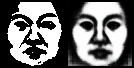

In [105]:
# sample = torch.randn(bs, 1024)
# compare_x = vae.decoder(sample)

# fixed_x, _ = next(iter(dataloader))
# fixed_x = fixed_x[:8]
fixed_x = dataset[randint(32, 100)][0].unsqueeze(0)

compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

In [43]:
sample = torch.randn(64, 64).to(device)
sample = model.decode(sample).cpu()
plt.imshow(sample)
plt.show()
pdb.set_trace()
save_image(sample.view(64, 1, 64, 64),
           'results/sample_' + str(epoch) + '.png')

RuntimeError: size mismatch, m1: [64 x 20], m2: [32 x 1024] at /Users/soumith/miniconda2/conda-bld/pytorch_1532623076075/work/aten/src/TH/generic/THTensorMath.cpp:2070